# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals prior to time-frequency-based analyses. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. Temporal filtering  
High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 

2. Create epochs  
Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 

3. Outlier data rejection  
3.1. Preliminar rejection  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.
3.2. ICA decomposition  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.
3.3. Autoreject  
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.
4. Outlier channel interpolation  
The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 


## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [11]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.io_raw import read_raw, create_epochs_from_raw
from eeg_preprocessing.utils.montage import set_raw_montage_from_locs

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data

EEG data can be imported using the custom read_raw() method that accepts BrainVision (.vhdr) and EDF (.edf) format. However, this custom method can be replaced and MNE functions used to import other file formats.

See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with importing data.  

In [3]:
# Set base path to EEG data
base_path = '/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data'

# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data', filename='', title='HTML(value='', layout=Layo…

In [5]:
# Load selected file
raw = read_raw(raw_file_path=fc.selected, add_info=False)
print(raw.info)

Extracting EDF parameters from /Volumes/crnl-memo-hd/raw_data_EEG/20210422171216_3_EEG PALT alatt.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 23 EEG
 custom_ref_applied: False
 fid: 20210422171216_3_EEG PALT alatt.easy_converted_
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-04-22 17:12:25 UTC
 nchan: 23
 projs: []
 sfreq: 500.0 Hz
>


## Set new montage

If the channel coordinates are missing from the raw file, it can be added separately using an mne-Python method.  
For this particular dataset, the locations file was downloaded from the Neuroelectrics homepage, make sure it is correct.


In [9]:
# Use the widget to navigate to the locations file  
fc = FileChooser(base_path)
fc.filter_pattern = ['*.locs']

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data', filename='', title='HTML(value='', layout=Layo…

In [26]:
# Set montage to raw
raw = set_raw_montage_from_locs(montage_file_path=fc.selected, raw=raw)

Applying channel locations to Raw instance.


##  Create epochs

Here we apply different cutoff frequencies than the default (0.5 - 45 Hz).

In [13]:
from eeg_preprocessing.utils.config import settings

settings['bandpass_filter']['low_freq'] = 1
settings['bandpass_filter']['high_freq'] = 30

In [27]:
epochs = create_epochs_from_raw(raw=raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Loading data for 102 events and 500 original time points ...
0 bad epochs dropped


## Run preprocessing


### 1.1. Preliminary epoch rejection

In [29]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad by amplitude:
	[ 77  78  79  80  94  96  97 101]
Bad by deviation:
	[ 95 101]
Bad by variance:
	[ 77  79  80  94  95  96  97 101]
Dropped 9 epochs: 77, 78, 79, 80, 94, 95, 96, 97, 101


### 1.2. Run ICA

Since this dataset only have 20 channels, the default number of components have to be adjusted. Similalry as before, we can change it here.

In [18]:
settings['ica']['n_components'] = 18

In [21]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 23 channels (please be patient, this may take a while)
Selecting by number: 19 components
 
Fitting ICA took 9.0s.


/Users/weian/crnl/eeg-preprocessing/eeg_preprocessing/preprocessing.py:46: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (12) and smallest (1.1e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 4
  ica.fit(epochs, decim=settings['ica']['decim'])


Not setting metadata
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


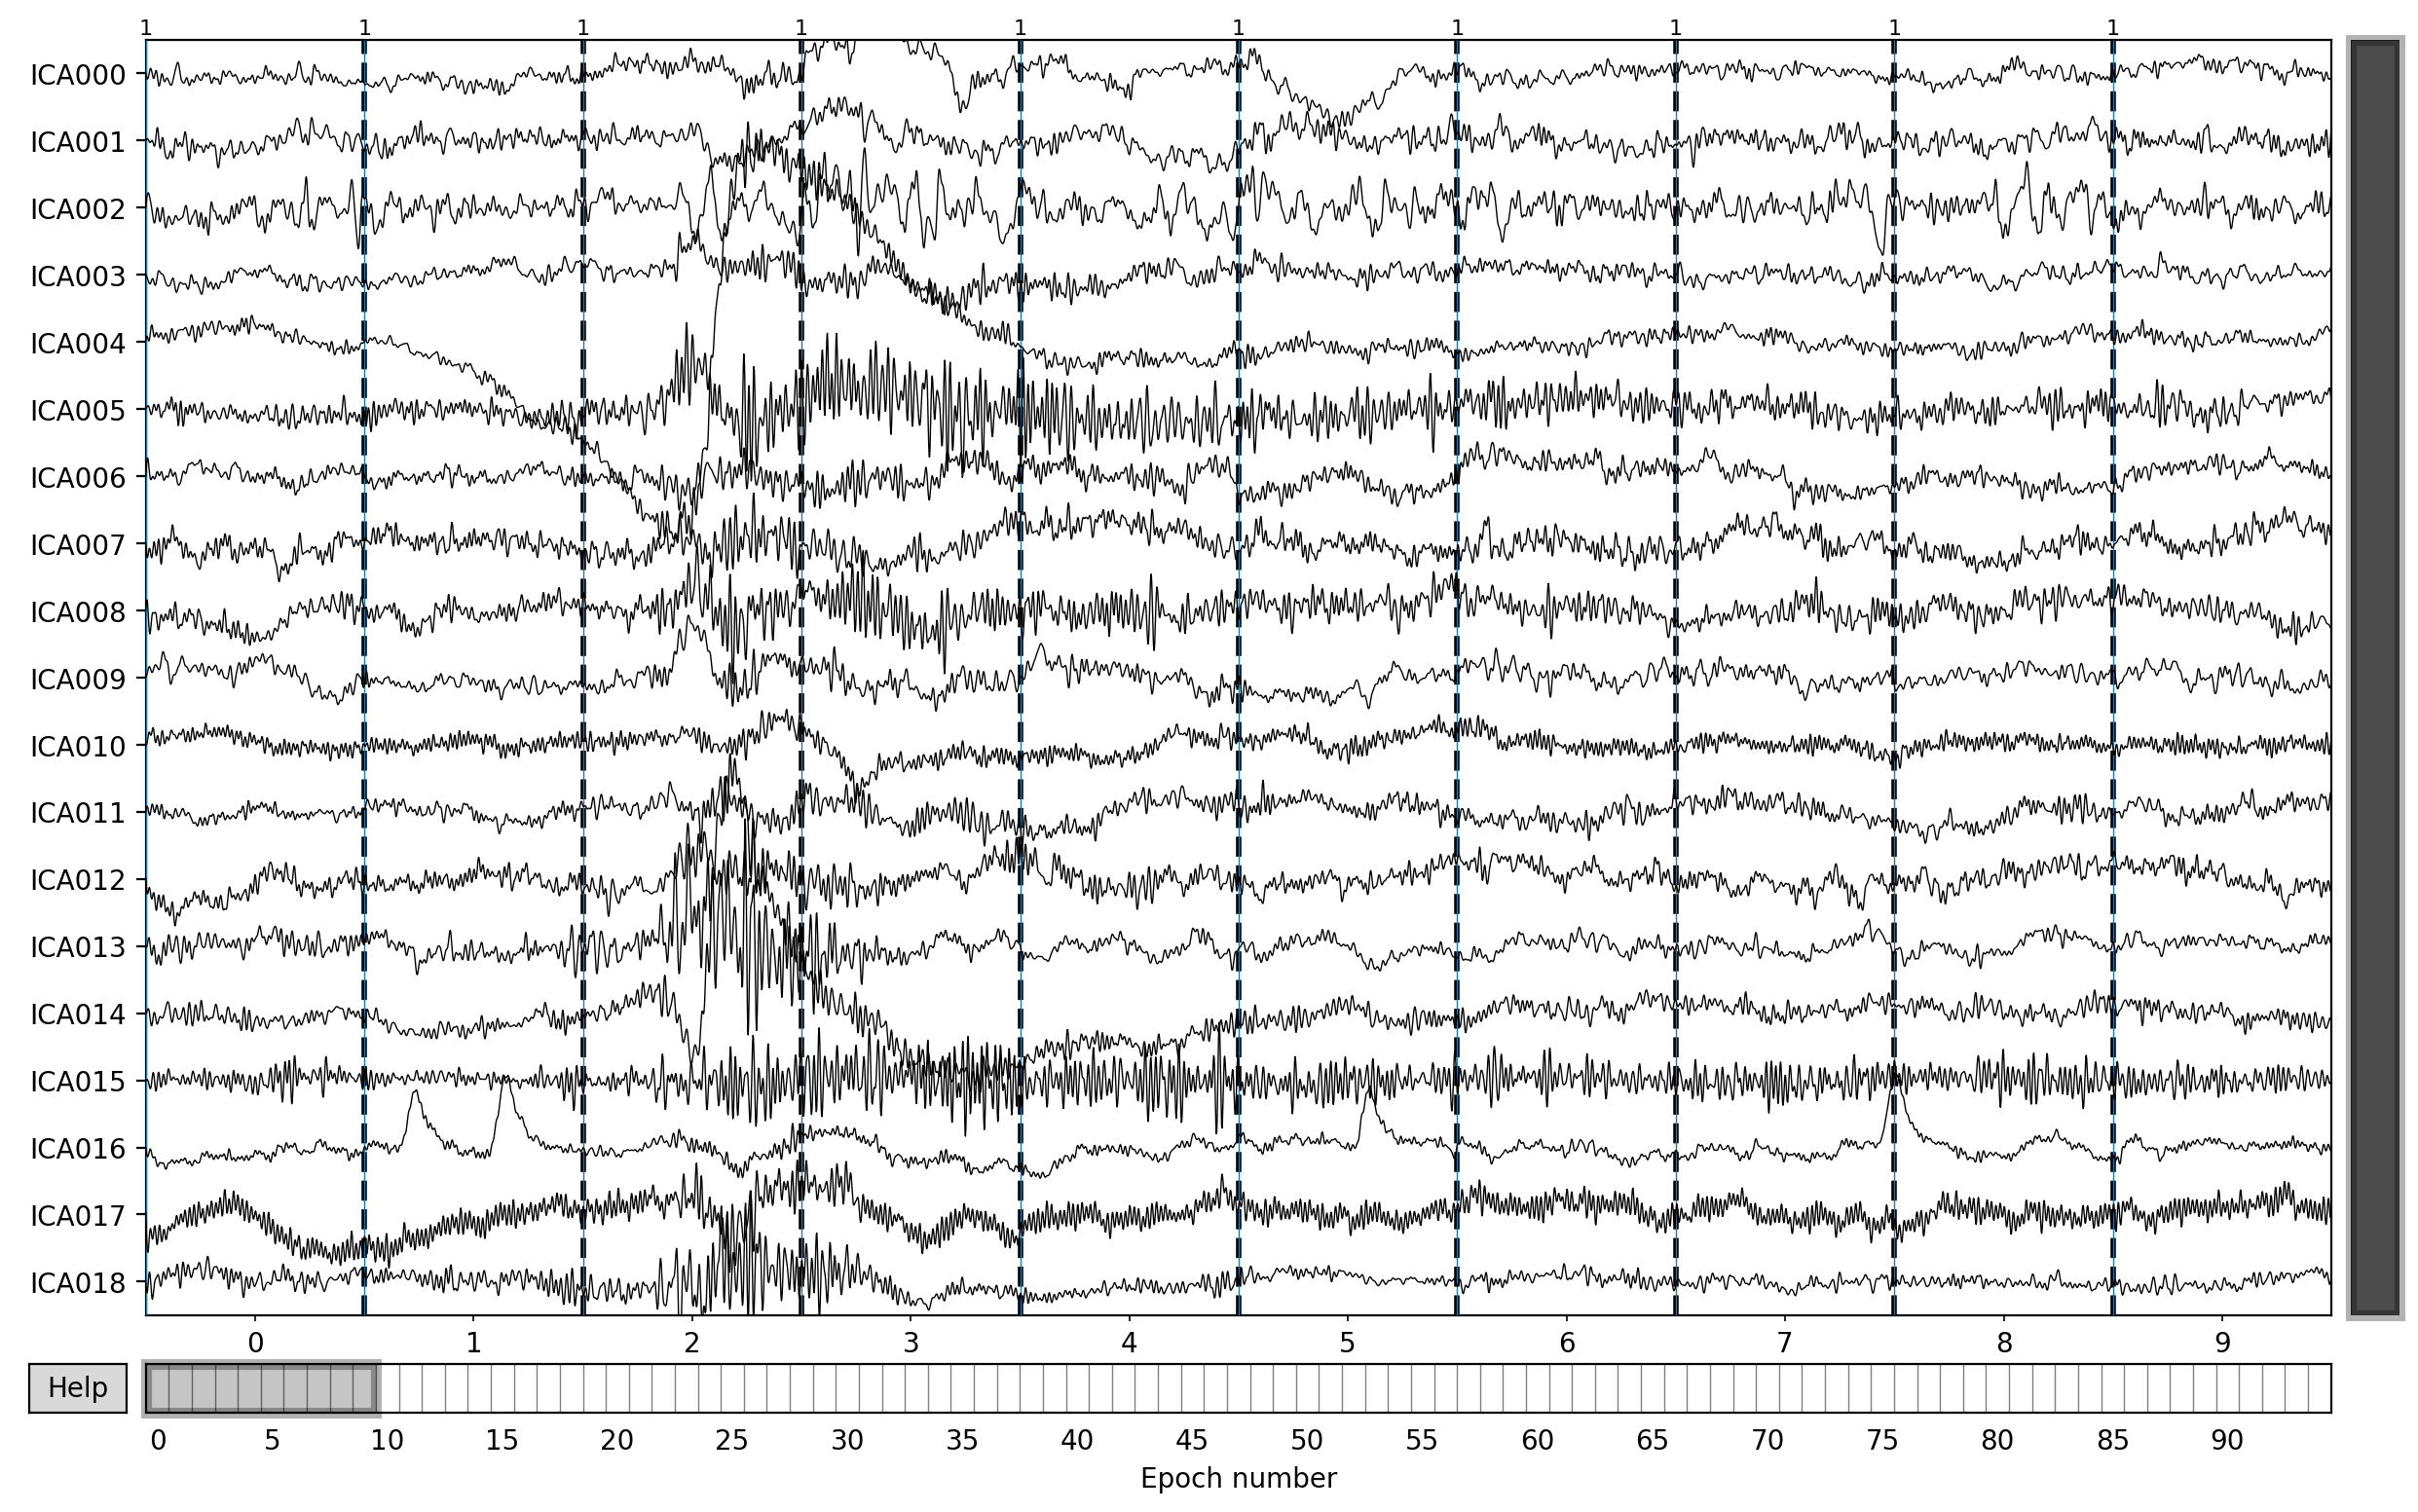

In [22]:
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster, start=0, stop=10)

In [ ]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
epochs_faster.plot(n_epochs=10, scalings={'eeg': 20e-6}, title=raw.info['fid'])

### 1.4. Save cleaned epochs (recommended)

In [24]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)


# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 2.1. Run autoreject

In [30]:
ar = run_autoreject(epochs_faster, n_jobs=11, subset=False)

Creating augmented epochs:  20%|██        | 4/20 [00:00<00:00, 36.58it/s]

Fitting autoreject on (n=93) epochs: 
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 20/20 [00:00<00:00, 43.24it/s]


Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 93/93 [00:00<00:00, 641.79it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs:  13%|█▎        | 12/93 [00:00<00:00, 111.22it/s]

Repairing epochs:  30%|███       | 28/93 [00:00<00:00, 134.71it/s]

Repairing epochs:  45%|████▌     | 42/93 [00:00<00:00, 118.30it/s]

Repairing epochs:  59%|█████▉    | 55/93 [00:00<00:00, 115.80it/s]

Repairing epochs:  73%|███████▎  | 68/93 [00:00<00:00, 117.95it/s]

Repairing epochs: 100%|██████████| 93/93 [00:00<00:00, 113.95it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:01,  6.60it/s]


Fold:  20%|██        | 2/10 [00:00<00:01,  7.38it/s]


Fold:  30%|███       | 3/10 [00:00<00:00,  8.00it/s]


Fold:  50%|█████     | 5/10 [00:00<00:00, 10.07it/s]


Fold:  70%|███





Estimated consensus=0.90 and n_interpolate=4


In [31]:
# Drop bad epochs (less strict)

reject_log = ar.get_reject_log(epochs_faster)

epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

Dropped 5 epochs: 3, 77, 78, 79, 80


In [34]:
# Drop bad epochs (more strict) - after visual inspection
idx = np.where(np.count_nonzero(reject_log.labels, axis=1) > epochs_faster.info['nchan']/2)[0].tolist()

# # Plot just the bad epochs!
if idx: 
    epochs_faster[idx].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                n_channels=32)
    
epochs_autoreject = epochs_faster.copy().drop(idx, reason='AUTOREJECT')

Dropped 20 epochs: 2, 3, 5, 17, 28, 43, 49, 51, 62, 66, 69, 77, 78, 79, 80, 81, 84, 86, 89, 92
Dropped 0 epochs: 
Channels marked as bad: none


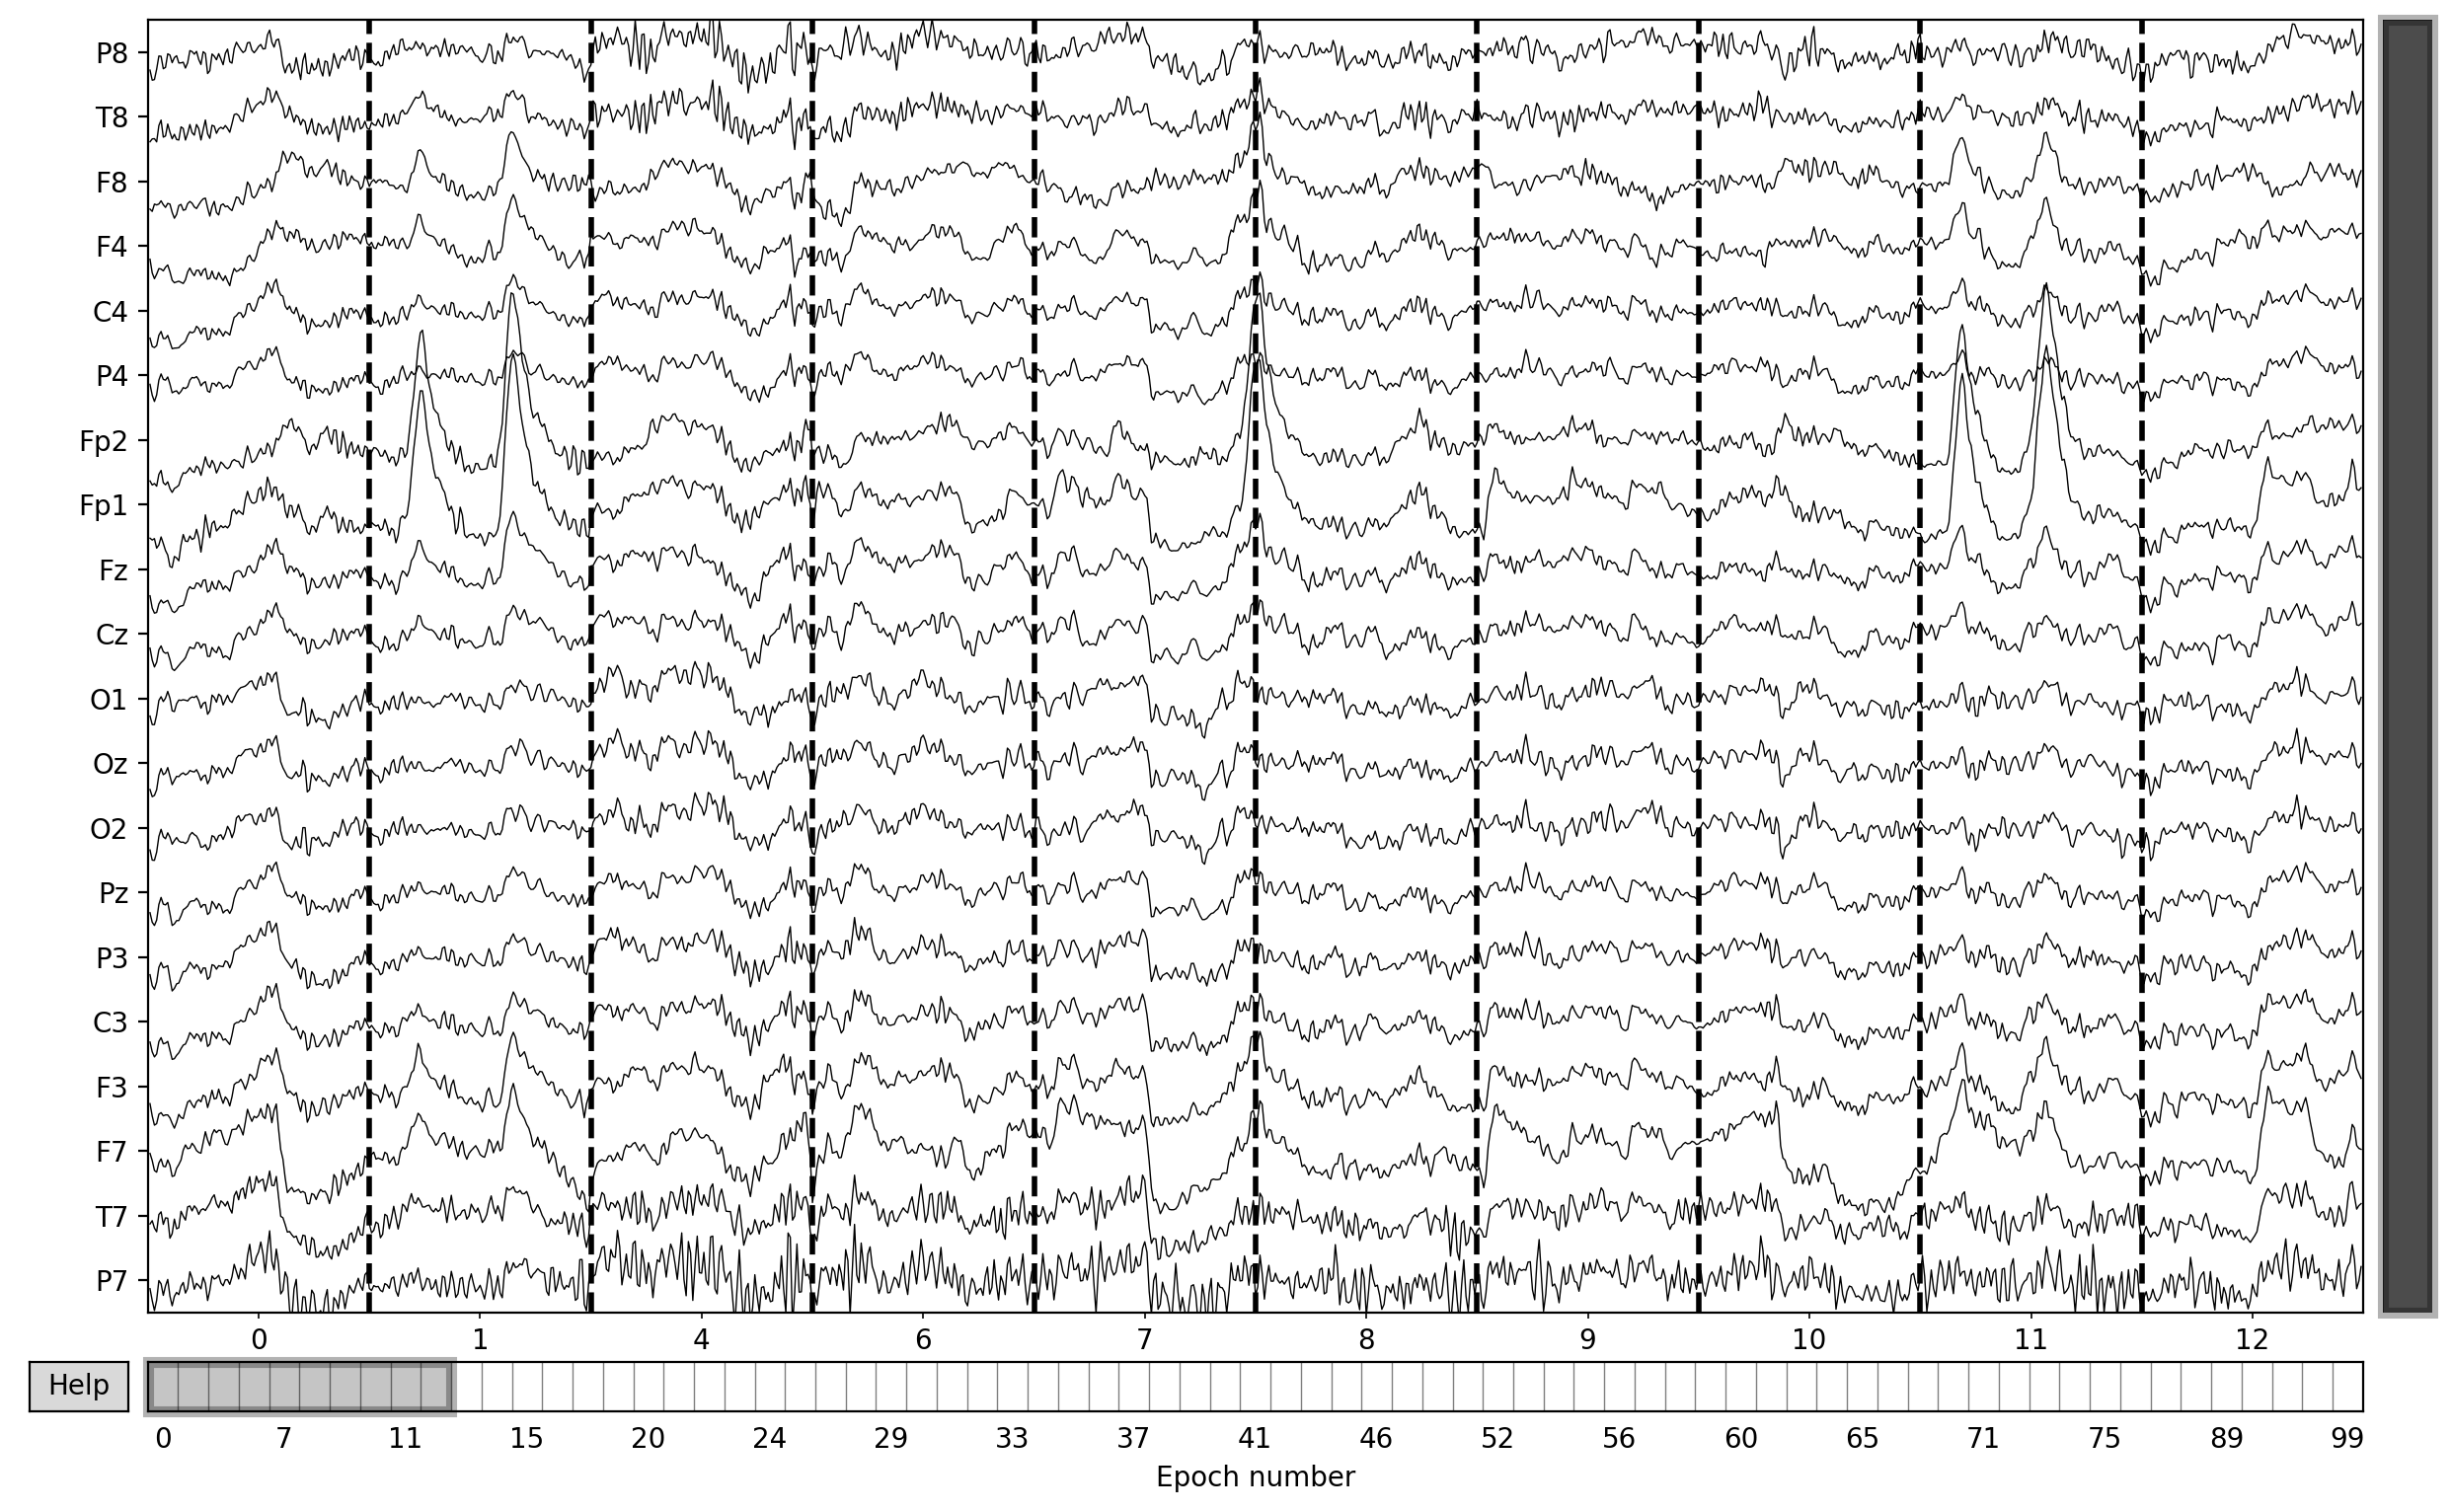

Dropped 0 epochs: 
Channels marked as bad: none


In [35]:
epochs_autoreject.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [36]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 3. Run ransac

In [37]:
epochs_ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=11)]: Done   2 out of   7 | elapsed:    0.8s remaining:    2.0s
[Parallel(n_jobs=11)]: Done   3 out of   7 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=11)]: Done   4 out of   7 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=11)]: Done   5 out of   7 | elapsed:    1.0s remaining:    0.4s


[Done]


[Parallel(n_jobs=11)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=11)]: Done   7 out of   7 | elapsed:    1.1s finished
/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/autoreject/ransac.py:226: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


In [38]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

<Info | 9 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 20 EEG
 custom_ref_applied: False
 dig: 20 items (20 EEG)
 fid: 20210422171216_3_EEG PALT alatt.easy_converted_
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2021-04-22 17:12:25 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
>

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

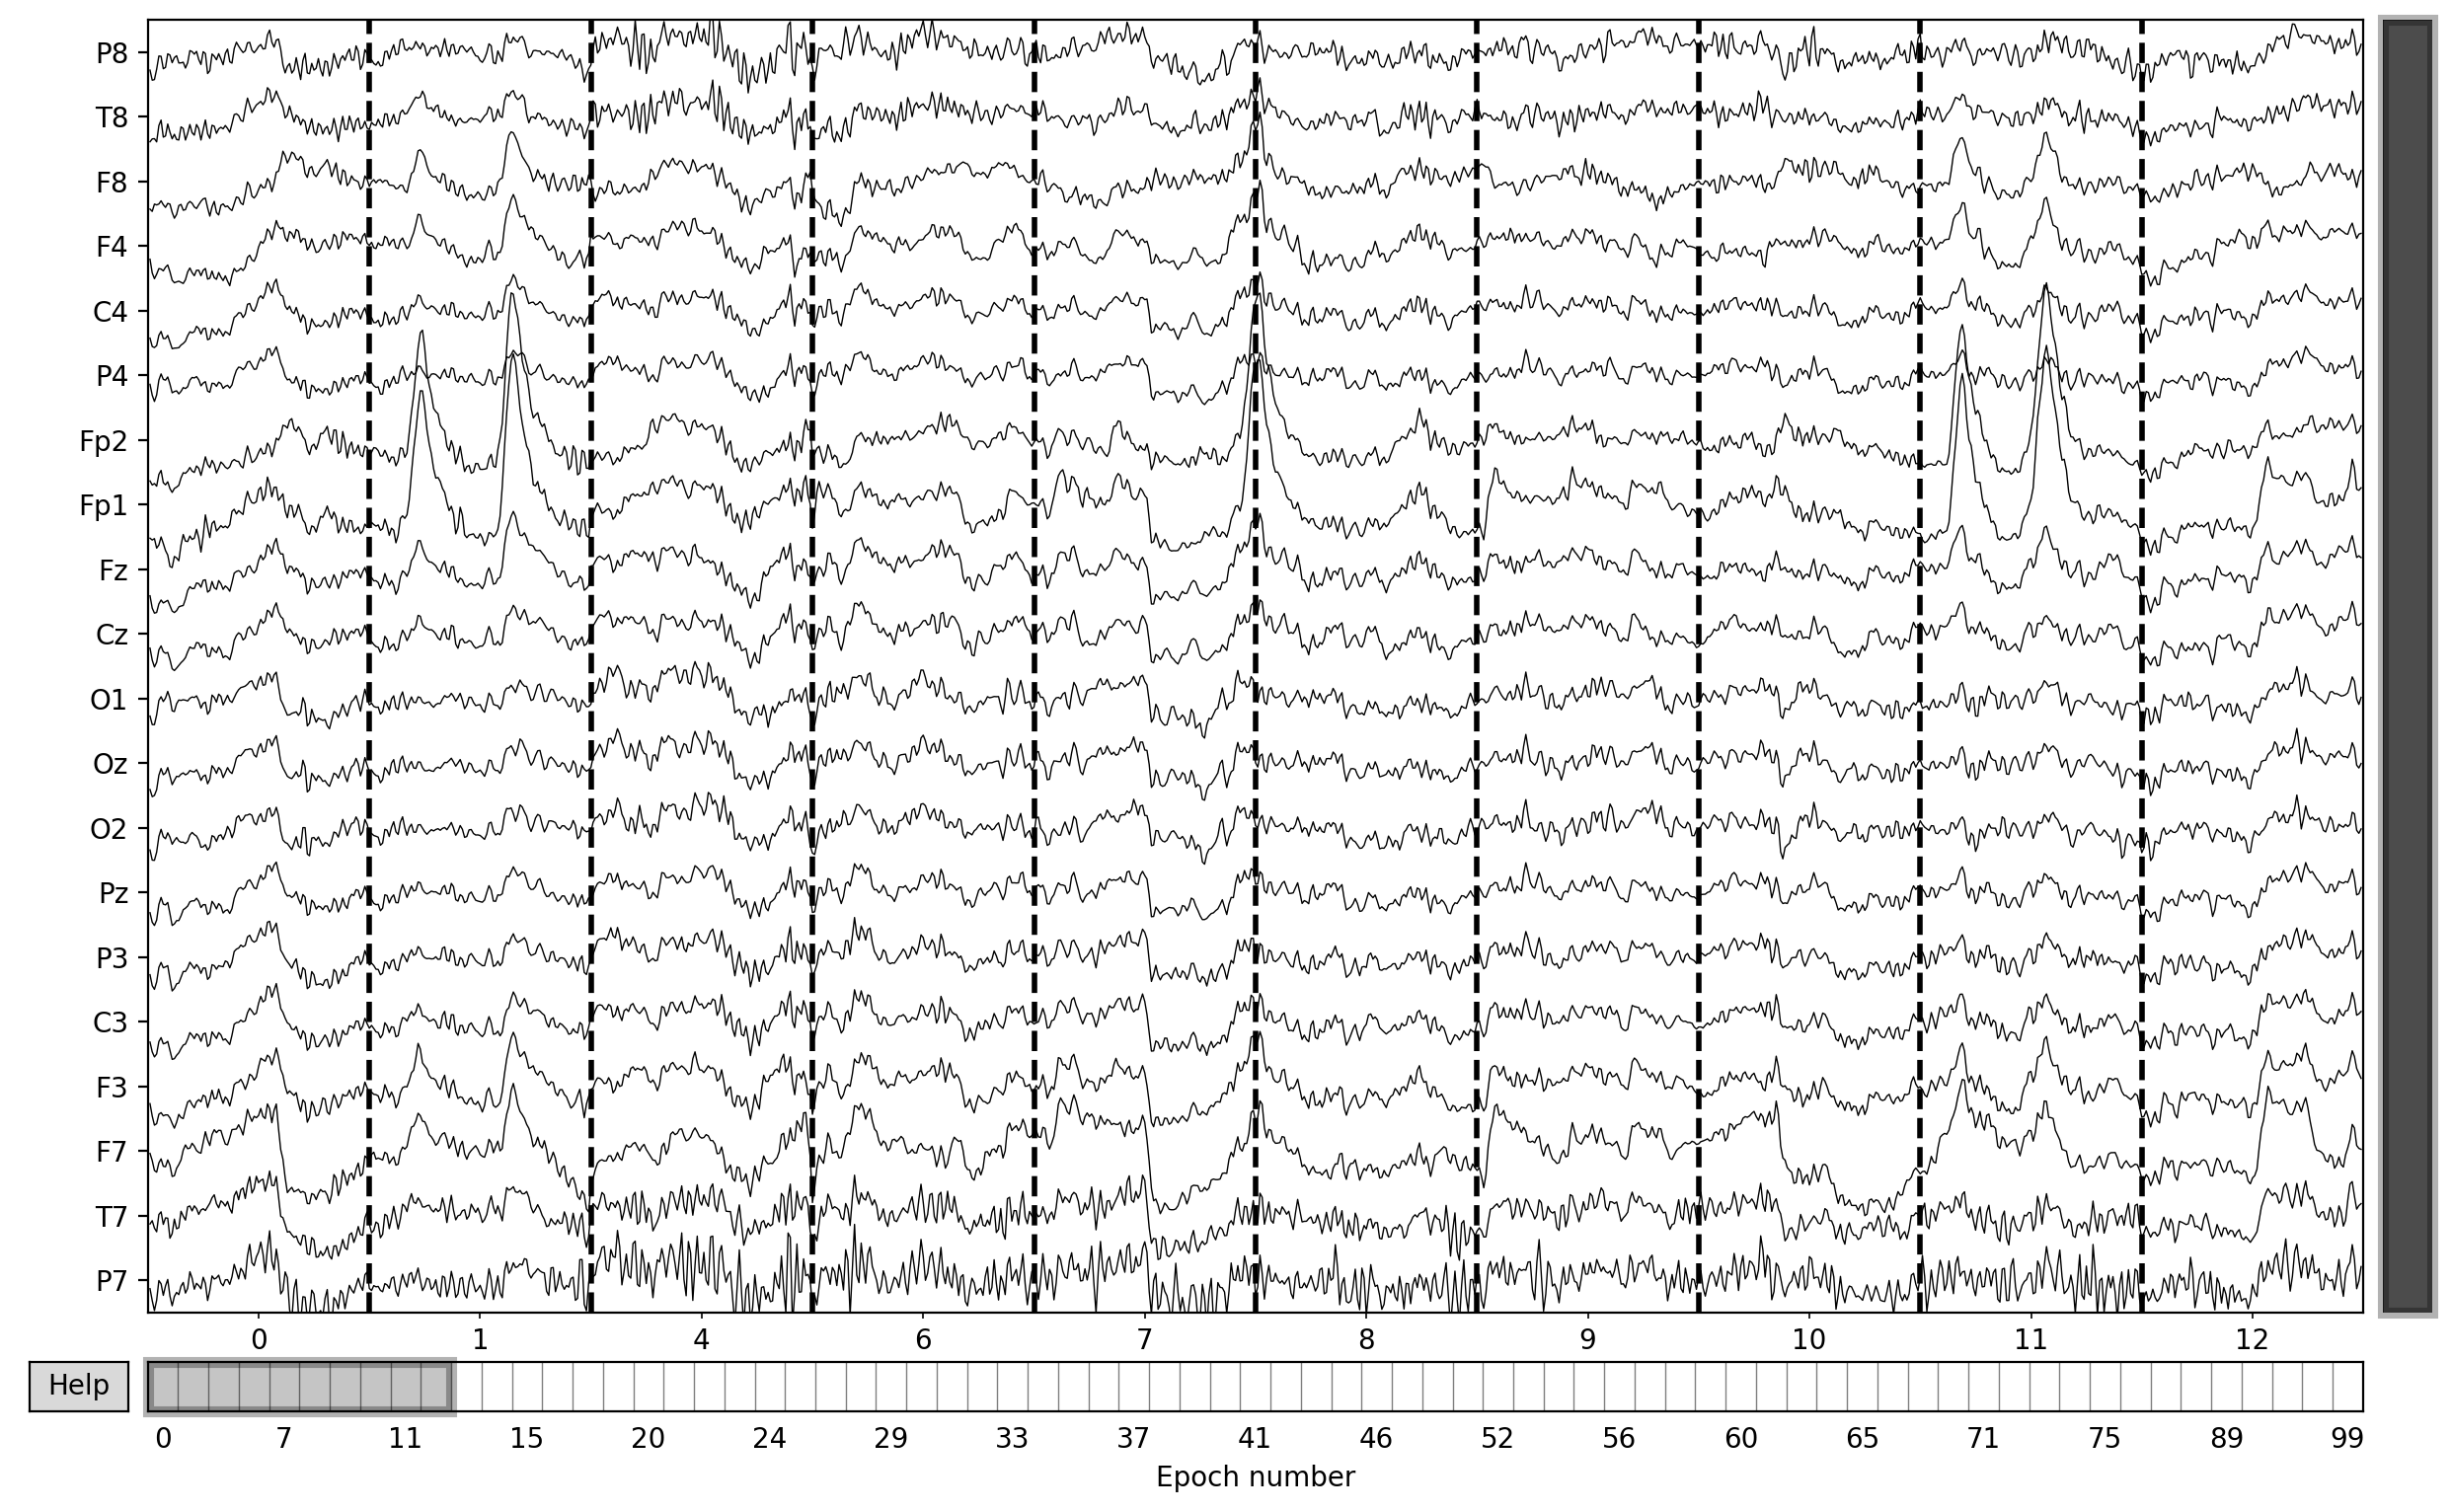

Dropped 0 epochs: 
Channels marked as bad: none


In [39]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# if there are additional channels marked for interpolation, we can interpolate them here.
if epochs_ransac.info['bads']:
    bads_str = ', '.join(epochs_ransac.info['bads'])
    epochs_ransac.interpolate_bads()
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)

In [40]:
epochs_ransac.plot_drop_log()

# Save Ransac cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [41]:
# cleanup from memory
del raw, epochs, epochs_autoreject, epochs_ransac

plt.close('all')